## Machine Learning Regression Strategy Code

We will implement a linear regression model that will predict the Day's High and Day's Low given its Day's Open. The key steps are:
1. Read stock data
2. Create X and y datasets
4. Preprocess the Data
5. Apply cross-validation
6. Split test and train data
7. Predict the High-Low Prices
8. Calculate Strategy returns
9. Analyse the performance

## Import the libraries

In [21]:
!pip install yfinance

In [22]:
# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Data manipulation
import pandas as pd
import numpy as np
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt

## Read EBS data

We have saved the OHLC Emergent Biosolutions Inc (EBS) stock data from Yahoo Finance.

[*********************100%***********************]  1 of 1 completed


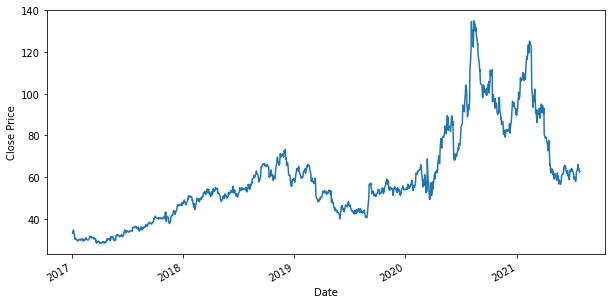

In [23]:
# Gather
stock = 'EBS'
Df = yf.download(stock, '2017-01-01')

# Plot the closing price
Df.Close.plot(figsize=(10, 5))
plt.ylabel("Close Price")
plt.show()

## Create input parameters

We will create custom indicators, which will help in making the prediction more accurate. 

We will compute the moving average of EBS for 3, 15 and 60 days and store it in S_3, S_15, and S_60, respectively. Then, we will compute the correlation between the closing price and 3 days moving average and store it in Corr. Next, we will compute the difference between High & Open, Open & Low, Open & previous day's Open, and Open & previous day's Close and store it in Std_U, Std_D, OD, and OL, respectively.

In [24]:
# Calculate 3-day moving average of close prices
Df['S_3'] = Df['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close prices
Df['S_15'] = Df['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close prices
Df['S_60'] = Df['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
Df['Corr'] = Df['Close'].shift(1).rolling(window=10).corr(Df['S_3'].shift(1))

Df['Std_U'] = Df['High']-Df['Open']
Df['Std_D'] = Df['Open']-Df['Low']

Df['OD'] = Df['Open']-Df['Open'].shift(1)
Df['OL'] = Df['Open']-Df['Close'].shift(1)

Df.tail()

,Open,High,Low,Close,Adj Close,Volume,S_3,S_15,S_60,Corr,Std_U,Std_D,OD,OL
Date,,,,,,,,,,,,,,
2021-07-21,65.250000,66.180000,63.730000,66.050003,66.050003,672100,63.743334,61.674000,61.209833,0.296373,0.930000,1.520000,1.560001,0.129997
2021-07-22,65.699997,66.279999,63.549999,63.650002,63.650002,284800,64.950002,61.810667,61.244166,0.568760,0.580002,2.149998,0.449997,-0.350006
2021-07-23,64.389999,64.699997,63.770000,64.389999,64.389999,234800,64.940002,61.854667,61.242500,0.691662,0.309998,0.619999,-1.309998,0.739998
2021-07-26,64.389999,64.389999,62.160000,62.369999,62.369999,238600,64.696668,61.878667,61.281500,0.717472,0.000000,2.230000,0.000000,0.000000
2021-07-27,61.779999,62.775002,60.814999,62.709999,62.709999,305504,63.470000,61.786000,61.268500,0.650608,0.995003,0.965000,-2.610001,-0.590000


## Create X and y datasets

A machine learning model's accuracy in making predictions depends on the kind of data provided to it.  
We will create an input dataset X and output datasets yU and yD for feeding into the linear regression model we are looking to build.

In [25]:
X = Df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr']]
X.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr
Date,,,,,,,
2021-07-21,65.250000,63.743334,61.674000,61.209833,1.560001,0.129997,0.296373
2021-07-22,65.699997,64.950002,61.810667,61.244166,0.449997,-0.350006,0.568760
2021-07-23,64.389999,64.940002,61.854667,61.242500,-1.309998,0.739998,0.691662
2021-07-26,64.389999,64.696668,61.878667,61.281500,0.000000,0.000000,0.717472
2021-07-27,61.779999,63.470000,61.786000,61.268500,-2.610001,-0.590000,0.650608


In [26]:
yU = Df['Std_U']
yU.tail()

Date
2021-07-21    0.930000
2021-07-22    0.580002
2021-07-23    0.309998
2021-07-26    0.000000
2021-07-27    0.995003
Name: Std_U, dtype: float64

In [27]:
yD = Df['Std_D']
yD.tail()

Date
2021-07-21    1.520000
2021-07-22    2.149998
2021-07-23    0.619999
2021-07-26    2.230000
2021-07-27    0.965000
Name: Std_D, dtype: float64

## Pipeline

In a machine learning model, there are many tasks that must be executed in sequential order. For this reason, we define a list containing tuples that specify the algo tasks given in the order of execution.

Specify in the steps a list of (name, transform) tuples. The 'name' is the variable name given to the task and 'transform' is the function used to perform the task. Then, sequentially apply a list of transforms specified in steps using the pipeline.

Syntax: 
```python
steps = [(name_1,transform_1), (name_2,transform_2),........(name_n,transform_n)]
Pipeline(steps)
```

## Data preprocessing
In a machine learning model, it is essential to feed the model with preprocessed data. Raw data contains many errors, and using such data will result in inconsistent and erroneous results. 

### Imputer
We instantiate the imputer function, which helps in identifying and replacing missing values. One might think it would be easy to drop the NaN values and then make the prediction based on the rest of the dataset. This will lead to losing out on the information provided by the non-NaN values in other parameters. To tackle this problem, we will be using the imputer function.

The imputer function takes the first argument as the type of missing value to be replaced. In this case, we have represented NaN in this field, as we are looking to replace the non-numerical values. The following argument to be entered is the strategy to be used for replacing the NaN values. We could either choose the mean, median or most frequent value of the dataset.

### Scaling
Suppose a feature has a variance of an order of magnitude larger than that of the other features. In that case, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. To achieve this, we call the Standard Scaler function.

In [28]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('linear',LinearRegression())]     
pipeline = Pipeline(steps)

## Hyperparameters

There are some parameters that the model itself cannot estimate, but we still need to account for them as they play a crucial role in increasing the performance of the system. Such parameters are called hyperparameters. Hear, including the intercept term in our calculations is something that we have chosen as the hyperparameter. You can add more hyperparameters to tune the algo.

In [29]:
parameters = {'linear__fit_intercept':[0,1]}

## Random search cross-validation
Cross-validation indicates the model’s performance in a practical situation. Cross-validation aims to test the model during the training phase to tackle problems like overfitting and give an insight into how the model will generalize to an independent dataset. We will use the `GridSearchCV` function, which is an inbuilt function for running cross-validation.

We have set `cv=5`, which implies that the grid search will consider 5 rounds of cross-validation for averaging the performance results.

In [30]:
reg = RandomizedSearchCV(pipeline, parameters, cv=5)

## Split test and train data

Now, we will split data into train and test data set. 

1. First, 80% of data is used for training and the remaining data for testing.
2. Fit the training data to a grid search function.

In [31]:
t = .8
split = int(t*len(Df))
reg.fit(X[:split],yU[:split])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('imputation',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
                                                            missing_values=nan,
                                                            strategy='most_frequent',
                                                            verbose=0)),
                                             ('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('linear',
                                        

## Prediction

We will call the `best_params_` function and pass the `linear_fit_intercept` as an argument to it. This is a boolean parameter that can only take either 0 or 1 as its value, indicating False and True, respectively. Please note that there is a double underscore after the word linear, as it indicates that the parameter after the double underscore belongs to the key before the double underscore.

In [32]:
best_fit = reg.best_params_['linear__fit_intercept']

We will call the `LinearRegression` function and pass the arguments as `fit_intercept = best_fit`, where `best_fit` is the value that decides the intercept parameter for the new instantiation of the `LinearRegression` function.

In [33]:
reg = LinearRegression(fit_intercept=best_fit)

We will call the imputer function to fill in all the NaN values with the most frequent values.

In [34]:
X = imp.fit_transform(X,yU)

We will fit the linear regression model on the train dataset and predict the upward deviation in the test dataset.

In [35]:
reg.fit(X[:split], yU[:split])
yU_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the dataframe
Df.reset_index(inplace=True)
Df['Max_U'] = 0
Df.loc[Df.index >= split, 'Max_U'] = yU_predict
Df.loc[Df['Max_U'] < 0, 'Max_U'] = 0

Similarly, we predict the downward deviation in the test dataset.

In [36]:
reg = RandomizedSearchCV(pipeline, parameters, cv=5)
reg.fit(X[:split], yD[:split])
best_fit = reg.best_params_['linear__fit_intercept']
reg = LinearRegression(fit_intercept=best_fit)
X = imp.fit_transform(X, yD)
reg.fit(X[:split], yD[:split])
yD_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the data frame
Df['Max_D'] = 0
Df.loc[Df.index >= split, 'Max_D'] = yD_predict
Df.loc[Df['Max_D'] < 0, 'Max_D'] = 0

Df.set_index('Date', inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


We will use the predicted upside deviation values to calculate the high price and the predicted downside deviation values to calculate the low price.

In [37]:
# We will use the predicted upside deviation values to calculate the high price
Df['P_H'] = Df['Open']+Df['Max_U']
Df['P_L'] = Df['Open']-Df['Max_D']

Df[['High', 'P_H', 'Low', 'P_L']].tail()

,High,P_H,Low,P_L
Date,,,,
2021-07-21,66.180000,66.626258,63.730000,63.743184
2021-07-22,66.279999,66.915840,63.549999,64.168453
2021-07-23,64.699997,65.666773,63.770000,63.098738
2021-07-26,64.389999,65.587435,62.160000,63.033649
2021-07-27,62.775002,62.764332,60.814999,60.427573


## Strategy returns

We will use the predicted high and predicted low values to determine whether to buy or sell the next day.

We will sell when
1. The actual high value is greater than the predicted high value and
2. The actual low value is greater than the predicted low value

We will buy when 
1. The actual high value is less than the predicted high value and 
2. The actual low value is less than the predicted low value

Next, we will compute the returns and strategy returns.

In [38]:
# Trading signal
Df['Signal'] = 0
Df.loc[(Df['High']>Df['P_H']) &(Df['Low']>Df['P_L']),'Signal'] = -1
Df.loc[(Df['High']<Df['P_H']) &(Df['Low']<Df['P_L']),'Signal'] = 1

# Compute returns 
Df['Ret'] = (Df['Close']-Df['Close'].shift(1))/Df['Close'].shift(1)

# Compute strategy returns(
Df['Ret1'] = Df['Ret']*(Df['Signal'].shift(1))

## Plot buy and hold returns vs. strategy returns

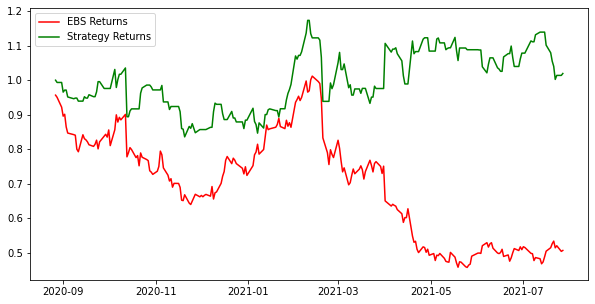

In [39]:
plt.figure(figsize=(10,5))
plt.plot(((Df['Ret'][split:]+1).cumprod()),color='r',label=(stock + ' Returns'))
plt.plot(((Df['Ret1'][split:]+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()

## Analyze the performance

In [40]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = Df['Ret1'][split:] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe 0.14712252632672412
